# Exporting high quality satellite images <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule),
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule),
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule)


## Background
Most of the case studies in this repository focus on quantitatively analysing satellite data to obtain insights into Australia's changing environment. 
However, satellite imagery also represents a powerful tool for visualisation.
Images taken by satellites can help explain physical processes, highlight change over time, or provide valuable context to better understand the impacts of recent environmental events such as flooding or fire. 
Satellite data can also be processed to create images of the landscape based on invisible wavelengths of light (e.g. false colour images), allowing us to obtain richer insights into features and processes that would otherwise be invisible to the human eye.

### Digital Earth Australia use case

**Digital Earth Australia** provides over three decades of satellite imagery across the entire continent of Australia. Satellite data from the [NASA/USGS Landsat program](https://www.usgs.gov/land-resources/nli/landsat) allow us to produce fortnightly images of Australia's diverse natural and artificial landscapes at any time since 1986. More recently, the [Copernicus Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) has provided even higher resolution imagery as frequently as every 5 days since 2015. 





## Description
This notebook provides an interactive tool for selecting, loading, processing and exporting satellite imagery as a high quality image file. 
This can be used in combination with the interactive [Digital Earth Australia Maps](maps.dea.ga.gov.au) platform to identify an image of interest, then download it using this notebook for use in other applications.

The tool supports Sentinel-2 and Landsat data, creating True and False colour images, and applying pansharpening to increase the resolution of Landsat 7 and 8 imagery.


***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages used for the analysis.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../Supplementary_data/')
from notebookapp_imageexport import run_imageexport_app


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Analysis parameters

The following cell sets important required parameters for the analysis:

* `date`: The exact date used to extract imagery (e.g. `date='1988-01-01'`).
* `satellites`: The satellite data to be used to extract the image. 
Three options are currently supported:
 
|                    |                                                                                                                          | 
|--------------------|--------------------------------------------------------------------------------------------------------------------------|
| **"Landsat"**        | Data from the Landsat 5, 7 and 8 satellites                                                                              |
| **"Sentinel-2"**     | Data from the Sentinel-2A and 2B satellites                                                                              |
| **"Sentinel-2 NRT"** | Most recent 'near real time' data from Sentinel-2A and 2B. Use this to obtain imagery acquired in the past three months. |
    
* `style`: The style used to produce the image. 
Two options are currently supported:

|                    |                                                                                                                          | 
|--------------------|--------------------------------------------------------------------------------------------------------------------------|
| **"True colour"**    | Creates a true colour image using the red, green and blue satellite bands                                                |
| **"False colour"**   | Creates a false colour image using short-wave infrared, infrared and green satellite bands.                              |

Optional parameters:

* `pansharpen`: Whether to apply pansharpening (using the Brovey Transform) to increase the resolution of Landsat 7 and 8 imagery from 30 m to 15 m pixels. This will only be applied if all the following are true: data comes from Landsat 7 or 8, style is set to "True colour", and no custom resolution is provided (see below).
* `resolution`: The spatial resolution to load data. By default, the tool will automatically set the best possible resolution depending on the satellites selected (i.e. 30 m for Landsat, 10 m for Sentinel-2).
Increasing this (e.g. to `resolution = (-100, 100)`) can be useful for loading large spatial extents.
* `vmin, vmax`: The minimum and maximum surface reflectance values used to clip the resulting imagery to enhance contrast. 
* `percentile_stretch`: A tuple of two percentiles (i.e. between 0.00 and 1.00) that can be used to clip the imagery to optimise the brightness and contrast of the image. 
If this parameter is used, `vmin` and `vmax` will have no effect.
* `power`: Raises imagery by a power to reduce bright features and enhance dark features. 
This can add extra definition over areas with extremely bright features like snow, beaches or salt pans.
* `standardise_name`: Whether to export the image file with a machine-readable file name (e.g. `sentinel-2b_2020-01-30_dampier-western-australia_true-colour-10-m-resolution.png`)


> **If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. 


In [9]:
# Required parameters
satellites = 'Sentinel-2'
date = '2021-03-17'
style = 'True colour'

# Optional parameters
pansharpen = True
resolution = None
vmin, vmax = (0, 2000)
percentile_stretch = (0.5, 99.5)
power = 0.8
standardise_name = False

## Select location and export image
Run the following cell to start the analysis. 
This will plot an interactive map that is used to select the area to load and export satellite imagery.

Select the `Draw a rectangle` or `Draw a polygon` tool on the left of the map, and draw a shape around the area you are interested in. 
When you are ready, press the green `done` button on the top right of the map. 
This will start loading the data, and then export an image file.

> Depending on the size of the area you select, this step can take **several minutes to complete**.
To keep load times reasonable, select an area **smaller than 30000 square kilometers** in size (this limit can be overuled by supplying the `size_limit` parameter in the `run_exportimage_app` function below).


In [10]:
from skimage.filters import unsharp_mask

funcs_list = [   
              # Apply different levels of unsharp masking to enhance
              # overall dynamic range, and improve fine scale detail
              lambda x: unsharp_mask(x, radius=50, amount=0.1),
              lambda x: unsharp_mask(x, radius=5, amount=0.2),
             ]
funcs_list = None

Map(center=[-25.18, 134.18], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43147 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:39725 Dashboard: /user/robbibt/proxy/43147/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB



Exporting image to Sentinel-2A - 2021-03-17 - Bollards Lagoon, South Australia - True colour, 10 m resolution.png.
This may take several minutes to complete...
Finished exporting image.


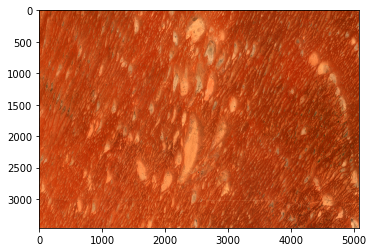

In [11]:
run_imageexport_app(date, satellites, style, pansharpen, resolution, 
                    vmin, vmax, percentile_stretch, power, standardise_name, 
                    funcs_list)

## Downloading exported image

The image export will be completed when `Finished exporting image` appears above, and a preview of your image is shown below the map.

The high resolution image file generated above will be saved to the same location you are running this notebook from (e.g. typically `Real_world_examples`). 
In JupyterLab, use the file browser to locate the image file with a name in the following format: 

`Landsat - 2021-03-31 - Canberra, Australian Capital Territory - True colour.png`

If you are using the **DEA Sandbox**, you can download the image to your PC by right clicking on the image file and selecting `Download`.

## Next steps
When you are done, return to the [Analysis parameters](#Analysis-parameters) section, modify some values and rerun the analysis. 
For example, you could try:

* Change `satellites` to `"Sentinel-2"` or `"Sentinel-2 NRT"` to export a Sentinel-2 image instead of Landsat.
* Modify `style` to `"False colour"` to export a false colour view of the landscape that highlights growing vegetation and water.
* Specify a custom resolution, e.g. `resolution = (-1000, 1000)`.
* Experiment with the `vmin`, `vmax`, `percentile_stretch` and `power` parameters to alter the appearance of the resulting image.


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [ ]:
import datacube
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)